# Panama Papers: Discovery of Corruption

* Students: Ilija Gjorgjiev, Gauthier Mueller, Mahmoud Zgolli
* Dataset: Panama Papers

In [51]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats.stats import pearsonr
import seaborn as sns
from scipy import stats
from py2neo import Graph, Node, Relationship
%matplotlib inline

In [2]:
#Load Data
panama_entity = pd.read_csv('./Data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
panama_officer = pd.read_csv('./Data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
panama_edges = pd.read_csv("./Data/panama_papers/panama_papers.edges.csv", low_memory=False)
panama_address = pd.read_csv("./Data/panama_papers/panama_papers.nodes.address.csv", low_memory=False)
panama_intermediary = pd.read_csv("./Data/panama_papers/panama_papers.nodes.intermediary.csv", low_memory=False)

In [3]:
#Convert Date/Time Values
panama_entity['incorporation_date'] = pd.to_datetime(panama_entity['incorporation_date'])
panama_entity['inactivation_date'] = pd.to_datetime(panama_entity['inactivation_date'])
#panama_entity['struck_off_date'] = pd.to_datetime(panama_entity['struck_off_date'])
panama_entity["closed_date"] = pd.to_datetime(panama_entity["closed_date"])

In [4]:
#Explore Data
print(panama_entity.shape)
panama_entity.head(2)

(213634, 17)


,node_id,name,jurisdiction,jurisdiction_description,country_codes,countries,incorporation_date,inactivation_date,struck_off_date,closed_date,ibcRUC,status,company_type,service_provider,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.",SAM,Samoa,HKG,Hong Kong,2006-03-23,2013-02-18,15-FEB-2013,NaT,25221,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",SAM,Samoa,HKG,Hong Kong,2006-03-27,2014-02-27,15-FEB-2014,NaT,25249,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN


In [5]:
print(panama_officer.shape)
panama_officer.head(2)

(238402, 7)


,node_id,name,country_codes,countries,sourceID,valid_until,note
0,12000001,KIM SOO IN,KOR,South Korea,Panama Papers,The Panama Papers data is current through 2015,NaN
1,12000002,Tian Yuan,CHN,China,Panama Papers,The Panama Papers data is current through 2015,NaN


In [6]:
print(panama_edges.shape)
panama_edges.head(2)

(674102, 8)


,START_ID,TYPE,END_ID,link,start_date,end_date,sourceID,valid_until
0,10000035,registered_address,14095990,registered address,NaN,NaN,Panama Papers,NaN
1,10000044,registered_address,14091035,registered address,NaN,NaN,Panama Papers,NaN


In [7]:
print(panama_address.shape)
panama_address.head(2)

(93454, 8)


,node_id,name,address,country_codes,countries,sourceID,valid_until,note
0,14000001,NaN,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,SGP,Singapore,Panama Papers,The Panama Papers data is current through 2015,NaN
1,14000002,NaN,"""Almaly Village"" v.5, Almaty Kazakhstan",KAZ,Kazakhstan,Panama Papers,The Panama Papers data is current through 2015,NaN


In [18]:
print(panama_intermediary.shape)
panama_intermediary.head(2)

(14110, 8)


,node_id,name,country_codes,countries,status,sourceID,valid_until,note
0,11000001,"MICHAEL PAPAGEORGE, MR.",ZAF,South Africa,ACTIVE,Panama Papers,The Panama Papers data is current through 2015,NaN
1,11000002,CORFIDUCIA ANSTALT,LIE,Liechtenstein,ACTIVE,Panama Papers,The Panama Papers data is current through 2015,NaN


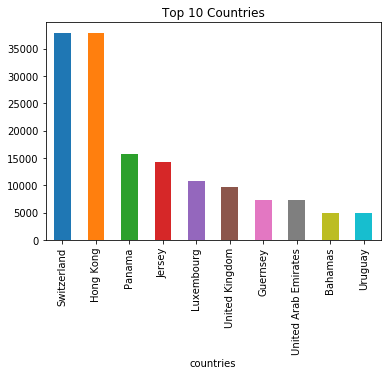

In [11]:
panama_entity.groupby("countries").count().sort_values(by=["node_id"],ascending = False)["node_id"].head(10).plot.bar(title="Top 10 Countries")

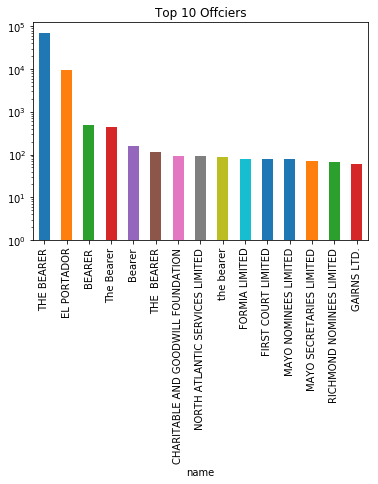

In [12]:
panama_officer.groupby("name").count().sort_values(by=["node_id"], ascending = False)["node_id"].head(15).plot.bar(log=True, title = "Top 15 Offciers")

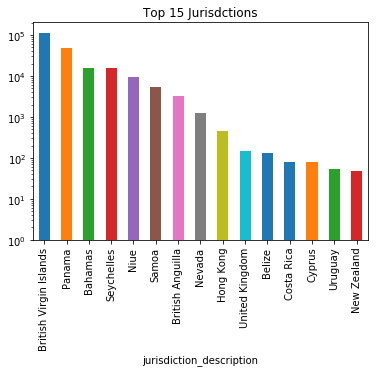

In [16]:
panama_entity.groupby("jurisdiction_description").count().sort_values(by=["node_id"], ascending = False)["node_id"].head(15).plot.bar(log=True, title = "Top 15 Jurisdctions")

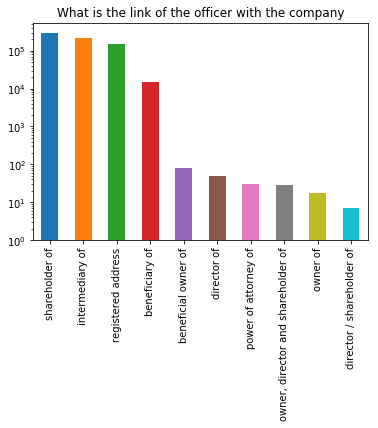

In [35]:
panama_edges["link"].value_counts().head(10).plot.bar(log=True, title = "What is the link of the officer with the company")

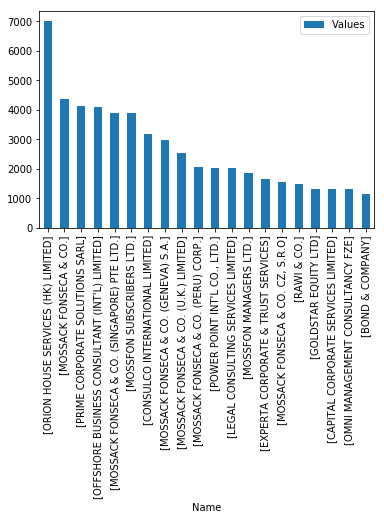

In [105]:
#Get the names of 20 most connected nodes in the graph.
node_ids = panama_edges["START_ID"].value_counts().head(20)
keys = node_ids.keys()
names = []
#Search for them in Officers, Intermediares or Entities
for i, nodeId in enumerate(node_ids):
    name = ""
    if keys[i] in panama_entity["node_id"].values:
        name = panama_entity[panama_entity["node_id"] == keys[i]]["name"]
        names.append(name)
    elif keys[i] in panama_intermediary["node_id"].values:
        name = panama_intermediary[panama_intermediary["node_id"] == keys[i]]["name"]
        names.append(name)
    elif keys[i] in panama_officer["node_id"].values:
        name = (panama_officer[panama_officer["node_id"] == keys[i]]["name"])
        names.append(name)
    else:
        name = panama_address[panama_address["node_id"] == keys[i]]["address"]
        names.append(name)

df = pd.DataFrame(data={"Name" : names, "Values" : node_ids.values})
df.set_index("Name", inplace=True)
df.plot.bar()



In [49]:
panama_intermediary[panama_intermediary["node_id"] == 11001746] 

,node_id,name,country_codes,countries,status,sourceID,valid_until,note
1756,11001746,ORION HOUSE SERVICES (HK) LIMITED,HKG,Hong Kong,ACTIVE,Panama Papers,The Panama Papers data is current through 2015,NaN


#### py2neo

run neo4j desktop for icij and once it is started run the following queries

In [54]:
graph = Graph("http://localhost:7474/browser/")

In [55]:
graph.run("MATCH p=()-[r:SAME_NAME_AS]->() RETURN p LIMIT 25").data()

[{'p': (CARIBBEAN OUTFITTERS N.V. - CARIBBEAN OUTFITTERS)-[:None {}]->(CARIBBEAN OUTFITTERS N.V.)},
 {'p': (CDR CONSULTANTS RETAILERS DEVELOPERS GROUP N.V. - EVA BOUTIQUE)-[:None {}]->(CDR CONSULTANTS RETAILERS DEVELOPERS GROUP N.V. - EVA BOUTIQUE)},
 {'p': (MONICA N.V.)-[:None {}]->(MONICA N.V.)},
 {'p': (CAPERUCITA ROJA)-[:None {}]->(CAPERUCITA ROJA)},
 {'p': (LA PATISSERIE)-[:None {}]->(LA PATISSERIE)},
 {'p': (CASA BLANCA N.V.)-[:None {}]->(CASA BLANCA N.V.)},
 {'p': (CASA BLANCA N.V.)-[:None {}]->(CASA BLANCA N.V.)},
 {'p': (A & R GEM STONES INTERNATIONAL N.V.)-[:None {}]->(A & R GEM STONES INTERNATIONAL N.V.)},
 {'p': (ESSO PETROLERA S.A. - ESSO PETROLERA S.A.)-[:None {}]->(ESSO PETROLERA S.A. - ESSO PETROLERA S.A.)},
 {'p': (SUGARBIRD N.V.)-[:None {}]->(SUGARBIRD N.V.)},
 {'p': (EDELWEISS DELICATESSEN)-[:None {}]->(EDELWEISS DELICATESSEN)},
 {'p': (CLAUDINE BEAUTY CLINIC)-[:None {}]->(CLAUDINE BEAUTY CLINIC)},
 {'p': (RISING DRAGON)-[:None {}]->(RISING DRAGON)},
 {'p': (FLORESTE

In [57]:
graph.run("MATCH p=()-[r:INTERMEDIARY_OF]->() RETURN p LIMIT 25").data()

[{'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(TIANSHENG INDUSTRY AND TRADING CO., LTD.)},
 {'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.)},
 {'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(HOTFOCUS CO., LTD.)},
 {'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(SKY-BLUE GIFTS & TOYS CO., LTD.)},
 {'p': (LOYAL PORT LIMITED)-[:None {}]->(FORTUNEMAKER INVESTMENTS CORPORATION)},
 {'p': (TWC MANAGEMENT LIMITED)-[:None {}]->(8808 HOLDING LIMITED)},
 {'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(KENT DEVELOPMENT LIMITED)},
 {'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(BONUS TRADE LIMITED)},
 {'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(AMARANDAN LTD.)},
 {'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(NEW IDEA LIMITED)},
 {'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(HUGH POWER LIMITED)},
 {'p': (ORION HOUSE SERVICES (HK) LIMITED)-[:None {}]->(ULTIMATE GROUP LIMITED)},
 {'p'

In [ ]:
graph."MATCH p=()-[r:UNDERLYING]->() RETURN p LIMIT 25"

In [ ]:
"MATCH p=()-[r:REGISTERED_ADDRESS]->() RETURN p LIMIT 25"